# Calculating Mantel correlations across the host phylogeny

The purpose of this notebook is to calculate Mantel correlations between phylogenetic distance and microbiome dissimilarity at each node of the host phylogenetic tree.

The resulting significance value (and correlation coefficient) can then be plotted against the host phylogeny to visualize changes in the strength of phylosymbiosis across the host phylogeny.

## Algorithm

- preorder traverse tree
- for each node:
  - grab tips associated with node
  - filter dm to those tips
  - grab patristic dm from those tips
  - calculate mantel
  - store values on node


In [1]:
import skbio as skb
import numpy as np
import pandas as pd
import seaborn as sns
from ecopy import Mantel

from matplotlib import pyplot as plt
import pylab as pl
from qiime2 import Artifact
from skbio import TreeNode
from skbio.stats.distance import mantel
from scipy.stats import linregress
from scipy.spatial.distance import squareform, pdist
from os.path import abspath, join
from os import makedirs

## Import data

### Host Tree

In [ ]:
# Export the wol qza tree to usable format 
!qiime tools export \
    --input-path /projects/vertebrate_assembly/07-combined-analysis-emp500-woltka/data/tree.qza \
    --output-path /projects/vertebrate_assembly /09-cophylogeny-analysis-jon-sanders/mantel-correlation/data/trees

In [2]:
tree_dir = abspath('/projects/vertebrate_assembly/09-cophylogeny-analysis-jon-sanders/mantel-correlation/data/trees')
host_tree_fp = join(tree_dir, 'total_timetree_names.all.nwk.tre')
host_tree= skb.io.read(host_tree_fp, format='newick', 
                       into=TreeNode,
                       convert_underscores=False)

host_tips = [x.name for x in host_tree.tips()]

In [3]:
# Visualize trees! 
print(host_tree.ascii_art())

                                                  /-Catostomus_catostomus
                                        /13------|
                                       |         |          /-Gila_robusta
                                       |          \14------|
                                       |                    \-Cyprinus_carpio
                                       |
                                       |                                                  /-Plethodon_cinereus
                                       |                                        /11------|
                                       |                              /10------|          \-Plethodon_shenandoah
                                       |                             |         |
                                       |                    /9-------|          \-Aneides_aeneus
                                       |                   |         |
                                       |                

In [4]:
print(host_tips)
len(host_tips)

['Catostomus_catostomus', 'Gila_robusta', 'Cyprinus_carpio', 'Plethodon_cinereus', 'Plethodon_shenandoah', 'Aneides_aeneus', 'Eurycea_bislineata', 'Eurycea_longicauda', 'Cornufer_guentheri', 'Mantella_aurantiaca', 'Theloderma_corticale', 'Dendrobates_tinctorius', 'Phyllobates_bicolor', 'Phyllobates_terribilis', 'Pedostibes_hosii', 'Anaxyrus_terrestris', 'Incilius_signifer', 'Atelopus_varius', 'Lepidobatrachus_laevis', 'Strabomantis_anomalus', 'Trachycephalus_resinifictrix', 'Litoria_infrafrenata', 'Hylomantis_lemur', 'Pseudechis_papuanus', 'Drymarchon_corais', 'Lampropeltis_getula', 'Lampropeltis_alterna', 'Elaphe_schrenckii', 'Nerodia_sipedon', 'Bitis_arietans', 'Crotalus_viridis', 'Bothriechis_schlegelii', 'Morelia_viridis', 'Aspidites_ramsayi', 'Python_molurus', 'Python_regius', 'Eunectes_murinus', 'Corallus_hortulanus', 'Boa_constrictor', 'Cyclura_collei', 'Iguana_iguana', 'Basiliscus_plumifrons', 'Anolis_smallwoodi', 'Anolis_allisoni', 'Anolis_barbatus', 'Uromastyx_aegyptia', 'Gon

1333

### Metadata

In [5]:
md_dir = '../data/metadata'
host_md_fp = join(md_dir, 'master_metadata_templeton_EMP_02092021.txt')
host_md = pd.read_csv(host_md_fp, sep='\t')

host_md['Taxonomy_Class'].value_counts()

Mammalia           57
Aves               54
Petromyzontida     17
Lepidosauria        5
Amphibia            4
Chelonia            3
Crocodylomorpha     2
Name: Taxonomy_Class, dtype: int64

In [6]:
host_md_in_tree = host_md.loc[(host_md['TimeTree_returned'].isin(host_tips))]

# filter to just tetrapods
include_classes = ['Amphibia',
                    'Mammalia',
                    'Aves',
                    'Crocodylomorpha',
                    'Lepidosauria',
                    'Chelonia',
                  'Petromyzontida']

host_md_in_tree_with_class = host_md_in_tree.loc[host_md_in_tree['Taxonomy_Class'].isin(include_classes)]
host_md_in_tree_with_class['Taxonomy_Class'].value_counts()

Mammalia           54
Aves               36
Petromyzontida     17
Lepidosauria        5
Amphibia            4
Chelonia            3
Crocodylomorpha     2
Name: Taxonomy_Class, dtype: int64

In [7]:
df_outer = host_md.merge(host_md_in_tree_with_class, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

df_outer['TimeTree_returned'] #### Fix this stuff in the metadata so maybe these babies could be incorporated

0     Giraffa_camelopardalis_reticulata
2             Diceros_bicornis_michaeli
15              Gorilla_gorilla_gorilla
23                   Varanus_acanthurus
44           Apteryx_australis_mantelli
63                Geospiza_acutirostris
65                Geospiza_acutirostris
67             Geospiza_septentrionalis
68             Geospiza_septentrionalis
69             Geospiza_septentrionalis
70             Geospiza_septentrionalis
71             Geospiza_septentrionalis
72             Geospiza_septentrionalis
73             Geospiza_septentrionalis
74             Geospiza_septentrionalis
75             Geospiza_septentrionalis
76             Geospiza_septentrionalis
86           Apteryx_australis_mantelli
87           Apteryx_australis_mantelli
94           Apteryx_australis_mantelli
95           Apteryx_australis_mantelli
Name: TimeTree_returned, dtype: object

### Microbial distance matrix

In [8]:
dm_dir = abspath('/projects/vertebrate_assembly/07-combined-analysis-emp500-woltka/data/core-metrics-results-low')
dm_fp = join(dm_dir, 'jaccard_distance_matrix.qza')
dm_art = Artifact.load(dm_fp)
dm = dm_art.view(skb.DistanceMatrix)

### Filter metadata, dm, and tree to same samples and species

In [9]:
md_ids = set(host_md['sample_name'])

dm_ids = set(dm.ids)

shared_ids = dm_ids & md_ids
len(shared_ids)

140

In [10]:
# Note that I filtered out 2 samples when processing hte dm
len(dm_ids)

140

In [11]:
len(md_ids)

142

In [12]:
len(shared_ids)

140

Filter dm and metadata:

In [13]:
host_md_f = host_md_in_tree_with_class
host_md_f = host_md_f.loc[host_md_f['sample_name'].isin(shared_ids)]
dm = dm.filter(list(shared_ids))

In [14]:
host_md_f.shape

(120, 327)

In [15]:
dm.shape

(140, 140)

Prune tree:

In [16]:
host_tree = host_tree.shear(host_md_f['TimeTree_returned'])
host_tips = [x.name for x in host_tree.tips()]

In [96]:
pd.set_option('display.max_columns', None)
print(host_tree.ascii_art())

                    /-Ichthyomyzon_fossor
          /2700----|
         |         |          /-Lampetra_appendix
         |          \2692----|
         |                    \-Petromyzon_marinus
         |
         |                                                  /-Uroplatus_lineatus
         |                                        /140-----|
         |                                       |          \-Rhacodactylus_leachianus
         |                              /139-----|
         |                             |         |          /-Eunectes_murinus
         |                             |          \126-----|
         |                             |                   |          /-Pseudopus_apodus
         |                             |                    \127-----|
         |                             |                              \-Varanus_albigularis
         |                             |
         |                             |                                         

## Test: overall mantel

First, we'll subset the host tree. For testing purposes, we can set subset to `True` to pull 100 random host species.

In [18]:
# Note if subset is false we are not testing but running the overall mantel
subset = False

In [19]:
#Reset host_md_f to host_md
host_md = host_md_f

In [20]:
# subset the tree if desired
if subset:
    host_subset = np.random.choice(host_tips, size=100, replace=False)
else:
    host_subset = host_tips

host_tree_subset = host_tree.shear(host_subset)

host_ids_subset = host_md.loc[host_md['TimeTree_returned'].isin(host_subset), 'sample_name']

In [21]:
len(host_ids_subset)

120

Within-species comparisons can artificially inflate the signal of 'phylosymbiosis' because they tend to be more similar for a host of reasons, and have a branch length of 0. Since we only care about between-species comparisons, we will subset to a single arbitrarily-chosen individual per species (if `one_per_sp == True`).

In [22]:
one_per_sp = True

In [23]:
if one_per_sp:
    host_md = host_md.loc[(host_md['sample_name'].isin(host_ids_subset)) &
                          (host_md['sample_name'].isin(dm.ids)),].groupby('TimeTree_returned').first()
    host_md =  host_md.loc[(host_md['sample_name'].isin(host_ids_subset)) &
                          (host_md['sample_name'].isin(dm.ids)),].groupby('TimeTree_returned').first().reset_index()
    host_ids_subset = list(set(host_ids_subset) & set(host_md['sample_name']))

In [24]:
len(host_ids_subset)

67

In [25]:
host_ids_subset

['13114.song.53.s009',
 '11166.ATL.24564.meerkat',
 '11166.ATL.24545.hawk',
 '11166.UM.24898.finch',
 '13114.song.75.s002',
 '13114.song.51.s015',
 '13114.song.51.s014',
 '11166.lamprey.24146.lamprey',
 '11166.FD.0126.hyena',
 '13114.song.51.s013',
 '2338.0620.8.I',
 '13114.song.51.s002',
 '11166.FD.0441.tinamou',
 '2338.0623.7.I',
 '11166.FD.0437.hyena',
 '13114.song.53.s007',
 '13114.song.53.s006',
 '11166.ATL.24487.vulture',
 '11166.AR.M18.flyingsquirrel',
 '11166.ATL.24553.hawk',
 '13114.song.53.s008',
 '11166.FD.0122.hyena',
 '11166.vbat.DR07.colon.vbat',
 '13114.song.51.s008',
 '13114.song.51.s009',
 '13114.song.52.s007',
 '11166.vbat.K3.colon.bat',
 '13114.song.51.s012',
 '13114.song.53.s010',
 '11166.ATL.25136.fossa',
 '11166.ATL.24614.prairiedog',
 '13114.song.53.s012',
 '13114.song.53.s001',
 '13114.song.51.s020',
 '13114.song.51.s006',
 '11166.lamprey.24159.lamprey',
 '13114.song.51.s004',
 '13114.song.52.s013',
 '11166.ATL.24548.falcon',
 '13114.song.52.s008',
 '13114.song.

### Calculate patristic distances

In [26]:
patristic_dm = host_tree_subset.tip_tip_distances()

In [27]:
patristic_dm.shape

(67, 67)

### Add diet distances

In [28]:
elton_cols = ['ET.Diet.Fruit',
             'ET.Diet.Inv',
             'ET.Diet.Nect',
             'ET.Diet.PlantO',
             'ET.Diet.Scav',
             'ET.Diet.Seed',
             'ET.Diet.Vect',
             'ET.Diet.Vend',
             'ET.Diet.Vfish',
             'ET.Diet.Vunk']

In [29]:
host_diet_df = host_md.loc[host_md[elton_cols].sum(axis=1) == 100,
                           ['sample_name'] + elton_cols].dropna()

In [30]:
host_diet_df.set_index('sample_name', inplace=True)

In [31]:
host_diet_df

,ET.Diet.Fruit,ET.Diet.Inv,ET.Diet.Nect,ET.Diet.PlantO,ET.Diet.Scav,ET.Diet.Seed,ET.Diet.Vect,ET.Diet.Vend,ET.Diet.Vfish,ET.Diet.Vunk
sample_name,,,,,,,,,,
13114.song.53.s012,20.0,10.0,0.0,50.0,0.0,20.0,0.0,0.0,0.0,0.0
13114.song.75.s002,0.0,80.0,0.0,0.0,0.0,0.0,10.0,0.0,10.0,0.0
13114.song.53.s005,20.0,20.0,0.0,20.0,0.0,20.0,10.0,10.0,0.0,0.0
2338.0623.7.I,80.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11166.vbat.K3.colon.bat,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11166.ATL.24545.hawk,0.0,10.0,0.0,0.0,0.0,0.0,30.0,60.0,0.0,0.0
13114.song.51.s013,20.0,20.0,0.0,30.0,0.0,20.0,0.0,0.0,0.0,10.0
2338.0620.8.I,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2338.0624.6.I,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
host_diet_df.shape

(50, 10)

In [33]:
# Loc a missing label is no longer supported --> host_diet_df = host_diet_df.loc[host_ids_subset,:].dropna()
host_diet_df=host_diet_df.loc[host_diet_df.index.intersection(host_ids_subset)]

In [34]:
host_diet_df.head()

,ET.Diet.Fruit,ET.Diet.Inv,ET.Diet.Nect,ET.Diet.PlantO,ET.Diet.Scav,ET.Diet.Seed,ET.Diet.Vect,ET.Diet.Vend,ET.Diet.Vfish,ET.Diet.Vunk
13114.song.53.s012,20.0,10.0,0.0,50.0,0.0,20.0,0.0,0.0,0.0,0.0
13114.song.75.s002,0.0,80.0,0.0,0.0,0.0,0.0,10.0,0.0,10.0,0.0
13114.song.53.s005,20.0,20.0,0.0,20.0,0.0,20.0,10.0,10.0,0.0,0.0
2338.0623.7.I,80.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11166.vbat.K3.colon.bat,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
diet_dm = skb.DistanceMatrix(squareform(pdist(host_diet_df.iloc[:, :], metric='braycurtis')))
diet_dm.ids = host_diet_df.index

In [36]:
diet_dm.shape

(50, 50)

In [37]:
rename_df = host_md.loc[host_md['sample_name'].isin(diet_dm.ids),
                             ['sample_name','TimeTree_returned']].set_index('sample_name')
rename = [rename_df.loc[x, 'TimeTree_returned'] for x in diet_dm.ids]

In [38]:
diet_dm.ids = rename

### Subset DM to remaining hosts and rename by tree

In [39]:
dm_subset = dm.filter(list(host_ids_subset))

In [40]:
dm_subset.shape

(67, 67)

In [41]:
rename_df = host_md.loc[host_md['sample_name'].isin(dm_subset.ids),
                             ['sample_name','TimeTree_returned']].set_index('sample_name')
rename = [rename_df.loc[x, 'TimeTree_returned'] for x in dm_subset.ids]

In [42]:
dm_subset.ids = rename

In [43]:
set(dm_subset.ids) == set(patristic_dm.ids)

True

# Method to run mantel iteratively across tree

In [44]:
def recursive_mantel(tree, dm1, dm2, min_size=7, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            corr, p, _ = mantel(dm1_s, dm2_s, **kwargs)
            node_dict[n.name] = (corr, p)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

In [45]:
def recursive_mantel_ecopy(tree, dm1, dm2, min_size=7, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            res = Mantel(dm1_s.data, dm2_s.data, **kwargs)
            
            node_dict[n.name] = (res.r_obs, res.pval)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

In [46]:
def recursive_partial_mantel_ecopy(tree, dm1, dm2, dmc, min_size=7, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            dmc_s = dmc.filter(tips)
            res = Mantel(dm1_s.data, dm2_s.data, d_condition=dmc_s.data, **kwargs)
            
            node_dict[n.name] = (res.r_obs, res.pval)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

In [47]:
# assign internal node names, non-integer

host_tree_subset.assign_ids()

for n in host_tree_subset.postorder():
    if n.is_tip():
        continue
    elif n.name[0].isdigit(): 
        n.name = "node%s" % n.name

In [48]:
tips = set(patristic_dm.ids) & set(dm_subset.ids) & set(diet_dm.ids)

In [49]:
len(tips)

50

Change `run` to `True` if re-calculating values

In [64]:
run = True

In [65]:
if run:
    node_dict_spearman = recursive_mantel(host_tree_subset, patristic_dm, dm_subset, method='spearman')

0.6992481203007519
1.0


In [66]:
if run:
    node_dict_pearson = recursive_mantel(host_tree_subset, patristic_dm, dm_subset, method='pearson')

0.6992481203007519
1.0


### Run partial Mantel tests, conditioned on diet

In [67]:
if run:
    node_dict_spearman_partial = recursive_partial_mantel_ecopy(host_tree_subset.shear(tips),
                                      patristic_dm.filter(tips),
                                      dm_subset.filter(tips),
                                      diet_dm.filter(tips),
                                      test='spearman')

/home/jhc103/miniconda3/envs/ecopy-qiime2-py36/lib/python3.6/site-packages/ecopy/matrix_comp/mantel.py:193: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(Z, y_flat)[0]


1.0


In [68]:
if run:
    node_dict_pearson_partial = recursive_partial_mantel_ecopy(host_tree_subset.shear(tips),
                                      patristic_dm.filter(tips),
                                      dm_subset.filter(tips),
                                      diet_dm.filter(tips),
                                      test='pearson')

1.0


## Write to file

In [69]:
out_dir = '../data/phylosymbiosis/mantel'

In [70]:
makedirs(out_dir, exist_ok=True)

In [71]:
if run:
    host_tree_subset.write(join(out_dir,'annotated_host_tree.tre'), format='newick')

In [72]:
if run:
    node_df_pearson = pd.DataFrame.from_dict(node_dict_pearson, orient='index')
    node_df_pearson.columns = ['r','p']
    node_df_pearson.to_csv(join(out_dir, 'mantel.jaccard.pearson.csv'))

In [73]:
if run:
    node_df_spearman =  pd.DataFrame.from_dict(node_dict_spearman, orient='index')
    node_df_spearman.columns = ['r','p']
    node_df_spearman.to_csv(join(out_dir, 'mantel.jaccard.spearman.csv'))

In [74]:
if run:
    node_df_pearson_partial = pd.DataFrame.from_dict(node_dict_pearson_partial, orient='index')
    node_df_pearson_partial.columns = ['r','p']
    node_df_pearson_partial.to_csv(join(out_dir, 'mantel_partial.jaccard.pearson.csv'))

In [75]:
if run:
    node_df_spearman_partial =  pd.DataFrame.from_dict(node_dict_spearman_partial, orient='index')
    node_df_spearman_partial.columns = ['r','p']
    node_df_spearman_partial.to_csv(join(out_dir, 'mantel_partial.jaccard.spearman.csv'))

## Calculate values for particular nodes

In [76]:
host_tree_subset = TreeNode.read(join(out_dir,'annotated_host_tree.tre'))

In [77]:
node_df_pearson = pd.read_csv(join(out_dir, 'mantel.jaccard.pearson.csv'), index_col=0)
node_df_spearman = pd.read_csv(join(out_dir, 'mantel.jaccard.spearman.csv'), index_col=0)
node_df_pearson_partial = pd.read_csv(join(out_dir, 'mantel_partial.jaccard.pearson.csv'), index_col=0)
node_df_spearman_partial = pd.read_csv(join(out_dir, 'mantel_partial.jaccard.spearman.csv'), index_col=0)

In [78]:
def node_values(tips, tree, node_df, tree_dm, dist_dm):
    node_name = tree.lca(tips).name
    
    r = node_df_pearson.loc[node_name, 'r']
    p = node_df_pearson.loc[node_name, 'p']
    
    pats = patristic_dm.filter(tips)
    dsts = dm_subset.filter(tips)

    x = pats.to_series()
    y = dsts.to_series()

    slope, _, _, _, _ = linregress(x, y)
    
    plot = sns.lmplot('x',
                      'y',
                      pd.DataFrame({'x': x, 'y': y}).reset_index(),
                      scatter_kws={'alpha':0.1})
    plt.ylim(0.5, 1.05)

    print(("r: {r}\n"
       "p: {p}\n"
       "m: {m:8.7f}\n").format(r=r, p=p, m=slope))
    
#     plot

In [89]:
# Look at our Taxonomy_Class & Taxonomy_Order
host_md['Taxonomy_Class'].value_counts()
host_md['Taxonomy_Order'].value_counts() ## <-- this isn't populated which could help with more analysis 

Carnivora             11
Falconiformes          6
Chiroptera             6
Squamata               5
Rodentia               4
Anura                  4
Petromyzontiformes     3
Testudines             3
Gruiformes             2
Perissodactyla         2
Pilosa                 2
Galliformes            2
Primates               2
Crocodylia             2
Casuariiformes         2
Struthioniformes       1
Anseriformes           1
Proboscidea            1
Ciconiiformes          1
Rheiformes             1
Cingulata              1
Sirenia                1
Passeriformes          1
Afrosoricida           1
Tinamiformes           1
Bucerotiformes         1
Name: Taxonomy_Order, dtype: int64

### Mammals

/home/jhc103/miniconda3/envs/ecopy-qiime2-py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


r: 0.09461956325620137
p: 0.316
m: 0.0001916



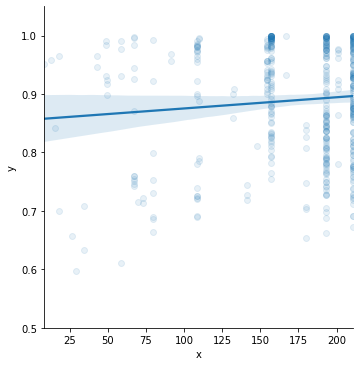

In [79]:
tips = set(host_md.loc[host_md['Taxonomy_Class'] == 'Mammalia','TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Birds

/home/jhc103/miniconda3/envs/ecopy-qiime2-py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


r: 0.2664142858248233
p: 0.004
m: 0.0003278



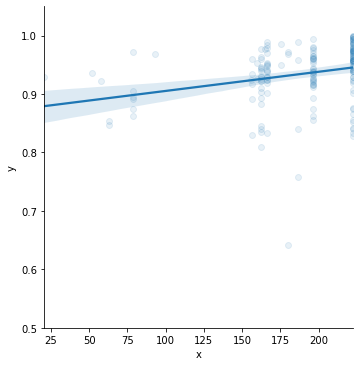

In [80]:
tips = set(host_md.loc[host_md['Taxonomy_Class'] == 'Aves','TimeTree_returned']) & set(host_subset)

node_va lues(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Bats

In [91]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Chiroptera',
                       'TimeTree_returned']) & set(host_subset)

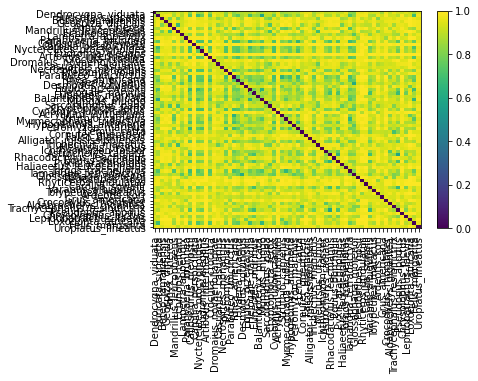

In [95]:
dm_subset

In [81]:
node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

KeyError: 'node2278'

### Cetartiodactyla

In [82]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Cetartiodactyla',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

ValueError: No tips found.

### Perissodactyla

In [83]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Perissodactyla',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

KeyError: 'node1891'

### Primates

In [84]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Primates',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

KeyError: 'node2555'

### Carnivora

/home/jhc103/miniconda3/envs/ecopy-qiime2-py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


r: 0.2257939623845374
p: 0.221
m: 0.0009900



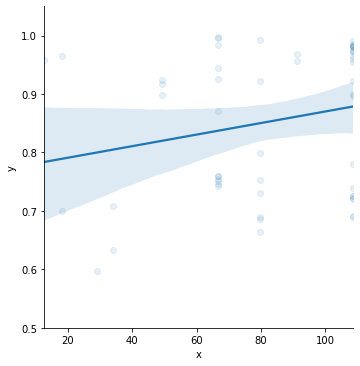

In [85]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Carnivora',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

### Rodentia

In [90]:
tips = set(host_md.loc[host_md['Taxonomy_Order'] == 'Rodentia',
                       'TimeTree_returned']) & set(host_subset)

node_values(tips, host_tree_subset, node_df_pearson, patristic_dm, dm_subset)

KeyError: 'node2409'

# Write tree color file

In [97]:
itol_dir = '../data/phylosymbiosis/itol'

In [98]:
makedirs(itol_dir, exist_ok=True)

In [99]:
import matplotlib as mpl

In [100]:
node_df_pearson['r'].max()

0.42316334933344746

In [101]:
node_df_spearman['r'].max()

0.3664302153099333

In [102]:
node_df_pearson_partial['r'].max()

0.4231633493334476

In [103]:
node_df_spearman_partial['r'].max()

0.4181818181818183

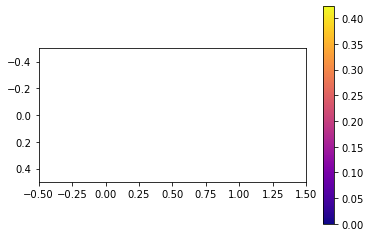

In [104]:
# create dummy invisible image
# (use the colormap you want to have on the colorbar)
cmax = node_df_pearson['r'].max()
img = plt.imshow(np.array([[0,cmax]]), cmap=mpl.cm.plasma)
img.set_visible(False)

plt.colorbar(orientation="vertical")

# add any other things you want to the figure.
# plt.plot(np.random.rand(30))

In [105]:
def colorbar(fp,
             cmax=1,
             size=(4,.7)):
    a = np.array([[0,cmax]])
    pl.figure(figsize=size)
    img = pl.imshow(a, cmap=mpl.cm.plasma)
    pl.gca().set_visible(False)
    cax = pl.axes([0.1, 0.4, 0.8, 0.5])
    pl.colorbar(orientation='horizontal', cax=cax)
    pl.savefig(fp)
    

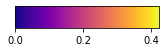

In [106]:
colorbar(join(itol_dir, 'mantel.jaccard.pearson.itol-r_colorbar.pdf'),
         cmax=node_df_pearson['r'].max(),
         size=(2.5,.6))

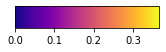

In [107]:
colorbar(join(itol_dir, 'mantel.jaccard.spearman.itol-r_colorbar.pdf'),
         cmax=node_df_spearman['r'].max(),
         size=(2.5,.6))

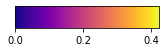

In [108]:
colorbar(join(itol_dir, 'mantel_partial.jaccard.pearson.itol-r_colorbar.pdf'),
         cmax=node_df_pearson_partial['r'].max(),
         size=(2.5,.6))

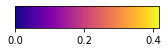

In [109]:
colorbar(join(itol_dir, 'mantel_partial.jaccard.spearman.itol-r_colorbar.pdf'),
         cmax=node_df_spearman_partial['r'].max(),
         size=(2.5,.6))

In [110]:
def get_colors(vals, col, cmap=mpl.cm.plasma):
    norm = mpl.colors.Normalize(vmin=0, vmax=np.max(vals))
    
    colors = []
    
    for i in vals:
        rgb = mpl.cm.ScalarMappable(norm=norm,
                                    cmap=cmap).to_rgba(i)
        hex_val = mpl.colors.rgb2hex(rgb)
        colors.append(hex_val)

    return(colors)

def write_itol_colors(node_df, col, fp, label='branch_colors'):
    out = ('DATASET_STYLE\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #ffff00\n\n'
           'DATASET_LABEL %s\n\n'
           'DATA\n'
           '#NODE_ID TYPE COLOR LABEL_OR_STYLE SIZE_FACTOR\n' % label)

    for i, row in node_df.iterrows():
        out += '{0} branch node {1} 2 normal\n'.format(i, row[col])

    with open(fp, 'w') as f:
        f.write(out)

In [ ]:
#LEGEND_TITLE,Dataset legend
#LEGEND_SHAPES,1,2,3
#LEGEND_COLORS,#ff0000,#00ff00,#0000ff
#LEGEND_LABELS,value1,value2,value3

In [111]:
node_df_pearson['r_color'] = get_colors(node_df_pearson['r'], col='r')
node_df_spearman['r_color'] = get_colors(node_df_spearman['r'], col='r')

In [112]:
node_df_pearson_partial['r_color'] = get_colors(node_df_pearson_partial['r'], col='r')
node_df_spearman_partial['r_color'] = get_colors(node_df_spearman_partial['r'], col='r')

In [113]:
write_itol_colors(node_df_pearson, 
                  'r_color', 
                  join(itol_dir, 'mantel.jaccard.pearson.itol-r_colors.txt'),
                  label='pearson_r')
write_itol_colors(node_df_spearman, 
                  'r_color',
                  join(itol_dir, 'mantel.jaccard.spearman.itol-r_colors.txt'),
                  label='spearman_r')


In [114]:
write_itol_colors(node_df_pearson_partial, 
                  'r_color', 
                  join(itol_dir, 'mantel_partial.jaccard.pearson.itol-r_colors.txt'),
                  label='pearson_r_partial')
write_itol_colors(node_df_spearman_partial, 
                  'r_color',
                  join(itol_dir, 'mantel_partial.jaccard.spearman.itol-r_colors.txt'),
                  label='spearman_r_partial')

### Write pie chart p-val indicator file

In [115]:
# 9132,0,50,11000
def write_pval_pies(node_df, col, fp, label='p-vals', breaks = [0.001, 0.01, 0.05]):
    header = ("DATASET_PIECHART\n"
              "SEPARATOR SPACE\n"
              "DATASET_LABEL %s\n"
              "COLOR #ff0000\n"
              "FIELD_COLORS #ff0000\n"
              "FIELD_LABELS p-value\n"
              "MAXIMUM_SIZE 30\n"
              "BORDER_WIDTH 0\n"
              "DATA\n" % label)
    
    break_sizes = [int(30 - i/len(breaks)*30) for i, x in enumerate(breaks)]
    pies = []
    for i, row in node_df.iterrows():
        size = 0
        for s, b in enumerate(breaks):
            if row[col] > b:
                continue
            else:
                size = break_sizes[s]
                break
        if size > 0:
            pies.append("{0} 0 {1} 1".format(i, size))
    
    out = header + '\n'.join(pies)
    
    with open(fp, 'w') as f:
        f.write(out)
            

In [116]:
write_pval_pies(node_df_pearson, 
                'p', 
                join(itol_dir, 'mantel.jaccard.pearson.itol-p_pies.txt'), 
                label='pearson_p')
write_pval_pies(node_df_spearman, 
                'p', 
                join(itol_dir, 'mantel.jaccard.spearman.itol-p_pies.txt'),
                label='spearman_p')

In [117]:
write_pval_pies(node_df_pearson_partial, 
                'p',
                join(itol_dir, 'mantel_partial.jaccard.pearson.itol-p_pies.txt'),
                label='pearson_p_partial')
write_pval_pies(node_df_spearman_partial, 
                'p',
                join(itol_dir, 'mantel_partial.jaccard.spearman.itol-p_pies.txt'),
                label='spearman_p_partial')

### Write clade highlighting

    

In [118]:
def write_clade_highlights(md_df, tree, tax_col, tree_col, fp,
                           label='clade_highlights',
                           colors=None, alpha=0.4, cmap=mpl.cm.Set3):
    out = ('DATASET_COLORSTRIP\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #b2df8a\n\n'
           'DATASET_LABEL %s\n\n'% label)
    
    taxa = md_df[tax_col].unique()
    
    if colors is None:
        clist = cmap(range(len(taxa)), alpha=alpha)
        rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                          int(x[1]*255),
                                          int(x[2]*255),
                                          x[3]) for x in clist]
        colors = {x: rgblist[i] for i, x in enumerate(taxa)}
    
    legend_shapes = ' '.join(['1']*len(taxa))
    legend_colors = ''
    legend_labels = ''
    
    for x in colors:
        legend_colors += ' %s' % colors[x]
        legend_labels += ' %s' % x
    
    out += ('LEGEND_TITLE host_colors\n'
            'LEGEND_SHAPES {0}\n'
            'LEGEND_COLORS{1}\n'
            'LEGEND_LABELS{2}\n\nDATA\n').format(legend_shapes,
                                            legend_colors,
                                            legend_labels)
        
    for taxon in taxa:
        tips = set(md_df.loc[md_df[tax_col] == taxon, tree_col])
        node = tree.lowest_common_ancestor(tips)
        
        out += "{0} {1}\n".format(node.name, colors[taxon])
#         out += "{0} range {1} {2}\n".format(node.name, colors[taxon], taxon)
        
    with open(fp, 'w') as f:
        f.write(out)


In [120]:
class_colors = {'Amphibia': '#b2df8a',
                 'Chelonia': '#33a02c',
                 'Lepidosauria': '#fb9a99',
                 'Crocodylomorpha': '#e31a1c',
                 'Aves': '#EACB47',
                 'Mammalia': '#6a3d9a',
                 'Petromyzontida': '#8adfc4'}
# Mammalia => purple, Aves => yellow, Crocodylomorpha => red, Lepidosauria => pink, 
# Chelonia => green, Amphibia => light green, Petromyzontida=> 

write_clade_highlights(host_md, 
                       host_tree_subset, 
                       'Taxonomy_Class', 
                       'TimeTree_returned',
                       join(itol_dir, 'mantel.itol-Class_colors.txt'),
                       colors=class_colors)

In [127]:
!head -n 20 ../data/phylosymbiosis/itol/mantel.itol-Class_colors.txt

DATASET_COLORSTRIP

SEPARATOR SPACE

COLOR #b2df8a

DATASET_LABEL clade_highlights

LEGEND_TITLE host_colors
LEGEND_SHAPES 1 1 1 1 1 1 1
LEGEND_COLORS #b2df8a #33a02c #fb9a99 #e31a1c #EACB47 #6a3d9a #8adfc4
LEGEND_LABELS Amphibia Chelonia Lepidosauria Crocodylomorpha Aves Mammalia Petromyzontida

DATA
node1659 #EACB47
node1666 #33a02c
node1655 #e31a1c
node2680 #6a3d9a
node39 #b2df8a
node139 #fb9a99


### Write flight annotations

In [122]:
def write_binary_colorstrip(md_df, col, tree_col, fp,
                           label='categorical_colorstrip',
                           colors=None, alpha=1, cmap=mpl.cm.Set3):
    out = ('DATASET_COLORSTRIP\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #8ab2df\n\n'
           'DATASET_LABEL %s\n\n'% label)
    
    values = md_df[col].unique()
    
    if colors is None:
        clist = cmap(range(len(values)), alpha=alpha)
        rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                          int(x[1]*255),
                                          int(x[2]*255),
                                          x[3]) for x in clist]
        colors = {x: rgblist[i] for i, x in enumerate(values)}
    
    legend_shapes = ' '.join(['1']*len(values))
    legend_colors = ''
    legend_labels = ''
    
    for x in colors:
        legend_colors += ' %s' % colors[x]
        legend_labels += ' %s' % x
    
    out += ('LEGEND_TITLE {0}\n'
            'LEGEND_SHAPES {1}\n'
            'LEGEND_COLORS{2}\n'
            'LEGEND_LABELS{3}\n\nDATA\n').format(label,
                                            legend_shapes,
                                            legend_colors,
                                            legend_labels)
        
    for taxon in md_df[tree_col]:
        
        out += "{0} {1}\n".format(taxon, colors[md_df.loc[md_df[tree_col] == taxon,
                                                          col].values[0]])
    
    with open(fp, 'w') as f:
        f.write(out)



In [123]:
flight_colors = {'flighted': '#000000',
                 'flightless': '#FFFFFF'}

write_binary_colorstrip(host_md, 
                        'flight_status', 
                        'TimeTree_returned', 
                        join(itol_dir, 'mantel.itol-flight_colors.txt'),
                        colors=flight_colors)

### Write diet barcharts

In [124]:
def get_qualitative_colors(fields, cmap=mpl.cm.Set3, alpha=0.4):
    clist = cmap(range(len(taxa)), alpha=alpha)
    rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                      int(x[1]*255),
                                      int(x[2]*255),
                                      x[3]) for x in clist]
    return(rgblist)

def format_iTOL_multibar(fields, md, 
                         tree_ref_col=None, 
                         field_colors=None, 
                         field_labels=None, 
                         dataset_label='Multibar Chart', 
                         dataset_color=None, 
                         legend=True, 
                         unstacked=False,
                         width=1000, 
                         margin=0,
                         alpha=0.8,
                        ):
    """
    fields: array of columns titles in [metadata] to chart
    metadata: pd.df containing samples to graph and data
    """
    
    if field_labels is None:
        field_labels=fields
    
    if field_colors is None:
        field_colors=get_qualitative_colors(fields, alpha=alpha)
    
    if tree_ref_col is None:
        tree_ref_col=metadata.columns[0]

    if dataset_color is None:
        dataset_color = "#00FF00"

    # remove nans
    metadata = md.loc[:,fields + [tree_ref_col]].dropna()
    
    outstring = ''
    
    outstring += 'DATASET_MULTIBAR\n'
    outstring += 'SEPARATOR TAB\n'
    outstring += 'DATASET_LABEL\t%s\n' % dataset_label
    outstring += 'COLOR\t%s\n' % dataset_color
    outstring += 'FIELD_COLORS\t%s\n' % '\t'.join(field_colors)
    outstring += 'FIELD_LABELS\t%s\n' % '\t'.join(field_labels)    
    
    if legend:
        outstring += 'LEGEND_TITLE\tDataset legend\n'
        outstring += 'LEGEND_SHAPES\t%s\n' % '\t'.join(['1']*len(fields))
        outstring += 'LEGEND_COLORS\t%s\n' % '\t'.join(field_colors)
        outstring += 'LEGEND_LABELS\t%s\n' % '\t'.join(field_labels)
    
    outstring += 'MARGIN\t%s\n' % margin
    outstring += 'WIDTH\t%s\n' % width

    if unstacked:
        outstring += 'ALIGN_FIELDS\t1\n'
        
    outstring += 'DATA\n'
    for index, row in metadata.iterrows():
        outstring += row[tree_ref_col].replace(' ', '_') + '\t%s\n' % '\t'.join([str(row[x]) for x in fields])

    return(outstring)


In [125]:
fields = ['ET.Diet.Fruit',
 'ET.Diet.Inv',
 'ET.Diet.Nect',
 'ET.Diet.PlantO',
 'ET.Diet.Scav',
 'ET.Diet.Seed',
 'ET.Diet.Vect',
 'ET.Diet.Vend',
 'ET.Diet.Vfish',
 'ET.Diet.Vunk']

bar = format_iTOL_multibar(fields, 
                     host_md, 
                     tree_ref_col='TimeTree_name', 
                     field_colors=['#a6cee3',
                                   '#cab2d6',
                                   '#1f78b4',
                                   '#33a02c',
                                   '#6a3d9a',
                                   '#b2df8a',
                                   '#fb9a99',
                                   '#e31a1c',
                                   '#ff7f00',
                                   '#fdbf6f'], 
                     field_labels=['Fruit',
                                   'Invertebrates',
                                   'Nectar',
                                   'Plants',
                                   'Scavenging',
                                   'Seeds',
                                   'Meat (Ectotherms)',
                                   'Meat (Endotherms)',
                                   'Meat (Fish)',
                                   'Meat (Unknown)'], 
                     dataset_label='Diet Barchart', 
                     dataset_color=None, 
                     legend=True,
                     width=200, 
                     alpha=1.0)

with open(join(itol_dir, 'mantel.itol-diet_bar.txt'), 'w') as f:
    f.write(bar)

In [128]:
!head -n 20 ../data/phylosymbiosis/itol/mantel.itol-diet_bar.txt

DATASET_MULTIBAR
SEPARATOR TAB
DATASET_LABEL	Diet Barchart
COLOR	#00FF00
FIELD_COLORS	#a6cee3	#cab2d6	#1f78b4	#33a02c	#6a3d9a	#b2df8a	#fb9a99	#e31a1c	#ff7f00	#fdbf6f
FIELD_LABELS	Fruit	Invertebrates	Nectar	Plants	Scavenging	Seeds	Meat (Ectotherms)	Meat (Endotherms)	Meat (Fish)	Meat (Unknown)
LEGEND_TITLE	Dataset legend
LEGEND_SHAPES	1	1	1	1	1	1	1	1	1	1
LEGEND_COLORS	#a6cee3	#cab2d6	#1f78b4	#33a02c	#6a3d9a	#b2df8a	#fb9a99	#e31a1c	#ff7f00	#fdbf6f
LEGEND_LABELS	Fruit	Invertebrates	Nectar	Plants	Scavenging	Seeds	Meat (Ectotherms)	Meat (Endotherms)	Meat (Fish)	Meat (Unknown)
MARGIN	0
WIDTH	200
DATA
Acryllium_vulturinum	20.0	10.0	0.0	50.0	0.0	20.0	0.0	0.0	0.0	0.0
Aonyx_cinerea	0.0	80.0	0.0	0.0	0.0	0.0	10.0	0.0	10.0	0.0
Ardeotis_kori	20.0	20.0	0.0	20.0	0.0	20.0	10.0	10.0	0.0	0.0
Artibeus_intermedius	80.0	10.0	10.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
Balantiopteryx_plicata	0.0	100.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
Buteo_jamaicensis	0.0	10.0	0.0	0.0	0.0	0.0	30.0	60.0	0.0	0.0
Callosciurus_prevostii	20.0